## Abstract and Methodologies
Automated decision systems are increasingly used in financial institutions to assess credit risk and determine loan eligibility. In this blog post, we build upon the theoretical framework of binary decision-making with a linear score function, applying it to a more realistic credit-risk prediction scenario. Our goal is twofold: first, to develop a score function and threshold that optimize a bank’s total expected profit while considering various borrower features; and second, to assess how this decision system impacts different demographic segments. By leveraging data-driven modeling, visualization, and profit-based optimization, we aim to create a more informed and equitable approach to automated lending decisions.

## Loading the data

In [101]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

In [102]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


## Analysis of Loan Intent by Age Group
This bar chart below shows how different age groups use their loans for various purposes—such as venture, education, medical, home improvement, personal, and debt consolidation. We can see that borrowers aged 18–29 make up a large portion of total loans, often driven by education and personal loan needs. As age increases, the number of loans generally decreases, but certain categories—like debt consolidation—can become more common in older groups.

Overall, this chart highlights that younger borrowers borrow a lot more money may be more focused on educational or personal financing, while older borrowers might shift their attention to consolidating debt or improving their homes. Understanding these patterns help us in understanding different patternns in who would default on a loan and not.

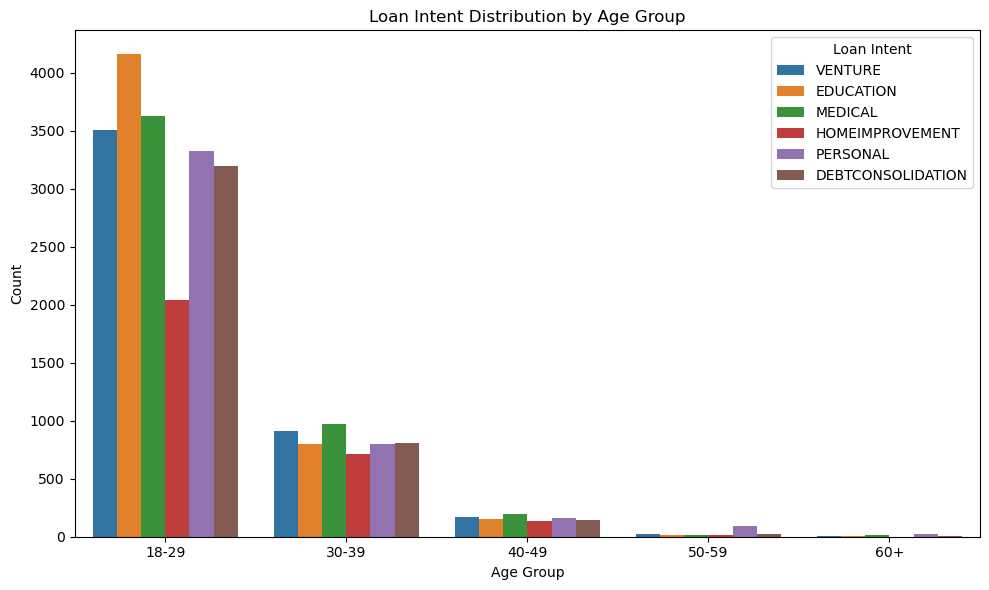

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df = pd.read_csv(url)

# Create additional features for analysis:
# 1. Age groups: we create bins to see how loan intent varies with age.
age_bins = [18, 30, 40, 50, 60, 100]
age_labels = ['18-29', '30-39', '40-49', '50-59', '60+']
df['age_group'] = pd.cut(df['person_age'], bins=age_bins, labels=age_labels)

# ---------------------------
# Visualization 1:
# How does loan intent vary with age and home ownership status?
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='age_group', hue='loan_intent')
plt.title('Loan Intent Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Loan Intent')
plt.tight_layout()
plt.show()


## Analysis of Average Loan Amount by Credit History Length
This bar chart shows how the average loan amount changes based on the number of years a borrower has had a credit history. In general, we see that some longer lengths of credit history are associated with higher average loan amounts than others, though the pattern isn’t strictly increasing or decreasing. This suggests that lenders may be willing to extend larger lines of credit to individuals with certain credit history profiles.

For our automated decision system, credit history length could be an important feature because it often reflects a borrower’s past experience with credit and repayment behavior. However, we must be mindful of fairness and potential biases: borrowers who are younger or newer to credit might be at a disadvantage if the model heavily weighs credit history length. Balancing profitability for the bank with equitable access to credit remains a key challenge in designing our scoring and thresholding methods.

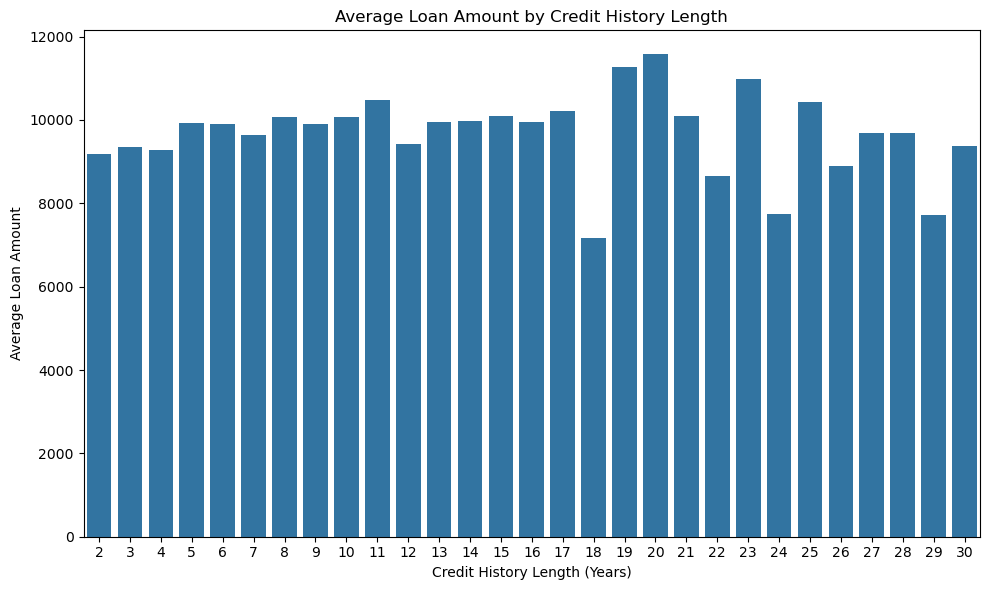

In [104]:

# 2. Employment length groups: useful for exploring patterns with job experience.
emp_bins = [0, 2, 5, 10, df['person_emp_length'].max()]
emp_labels = ['0-1 yrs', '2-4 yrs', '5-9 yrs', '10+ yrs']
df['emp_length_group'] = pd.cut(df['person_emp_length'], bins=emp_bins, labels=emp_labels)

# ---------------------------
# Visualization 2:
# Which segments are offered different interest rates? Compare distributions by home ownership.
plt.figure(figsize=(10, 6))
avg_loan = df.groupby('cb_person_cred_hist_length')['loan_amnt'].mean().reset_index()
sns.barplot(data=avg_loan, x='cb_person_cred_hist_length', y='loan_amnt')
plt.title('Average Loan Amount by Credit History Length')
plt.xlabel('Credit History Length (Years)')
plt.ylabel('Average Loan Amount')
plt.tight_layout()
plt.show()


## Analysis of Loan Amount vs. Loan % of Income by Home Ownership
In our scatter plot below, each dot represents a borrower, with the x-axis showing how large the loan is relative to their income (as a percentage) and the y-axis showing the absolute loan amount. The colors indicate different types of home ownership (RENT, MORTGAGE, OWN, OTHER).

As you can see, the data points overlap heavily, making the chart look cluttered. To get a clearer picture, I wo;; split these data into separate graphs for each home ownership category. This will help us see more nuanced patterns—like whether renters tend to have higher loan-to-income ratios compared to those who own or have a mortgage.

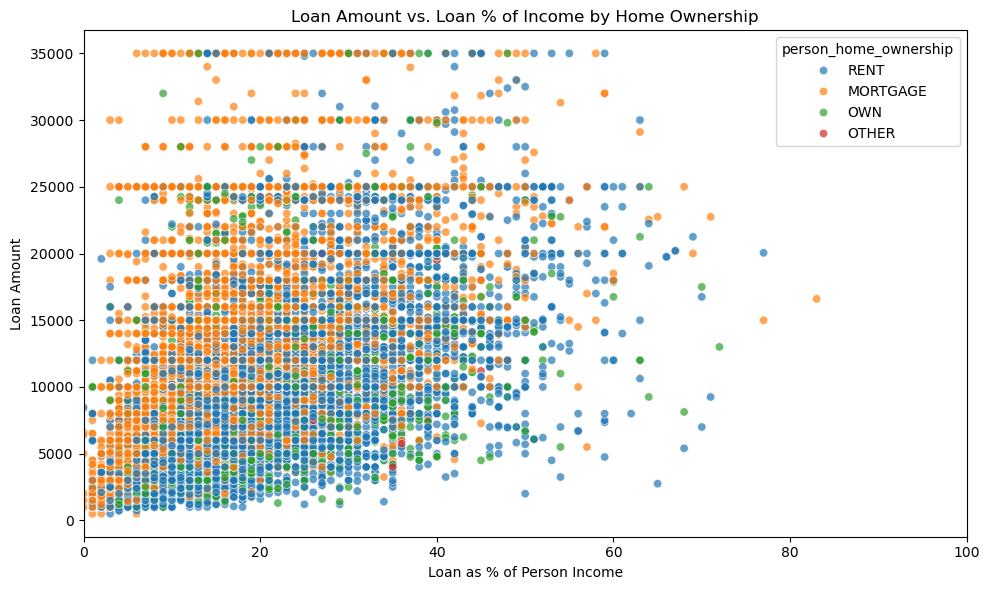

In [105]:
df['loan_percent_income_pct'] = df['loan_percent_income'] * 100
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, 
    x='loan_percent_income_pct', 
    y='loan_amnt', 
    hue='person_home_ownership',
    alpha=0.7
)
plt.title('Loan Amount vs. Loan % of Income by Home Ownership')
plt.xlabel('Loan as % of Person Income')
plt.ylabel('Loan Amount')
plt.xlim(0, 100)  # Focus on 0–100% if most loans fall in this range
plt.tight_layout()
plt.show()

## Analysis of Loan Amount vs. Loan % of Income by Home Ownership (Separated Plots)

By splitting the data into four subplots (one for each home ownership category), we can see that:

* Renters typically have loan amounts averaging around $10,000–$12,000, with a wide spread of loan-to-income ratios (averaging around 15–20%). In addition to this we see the most clustering for this group which means, in our dataset most of the people taking our loans are from this group.

* Mortgage holders often take out larger loans (averaging $16,000–$18,000) but may have lower loan-to-income ratios (closer to 10% on average). 

* Owners (those who fully own their homes) tend to borrow moderate amounts ($12,000–$15,000) at ratios of around 12–15%. 

* Others (less common categories) show a broad mix but generally fall between these ranges.

These distinctions are important for our automated decision system, since each home ownership group presents a different risk and borrowing profile. When designing a score function and threshold to maximize the bank’s profit, it’s important for us to consider whether certain groups (like renters) might be unfairly penalized if they tend to have higher loan-to-income ratios. Ultimately, these separate plots help us fine-tune our model so that we balance profitability with equitable access to credit across different segments of borrowers.

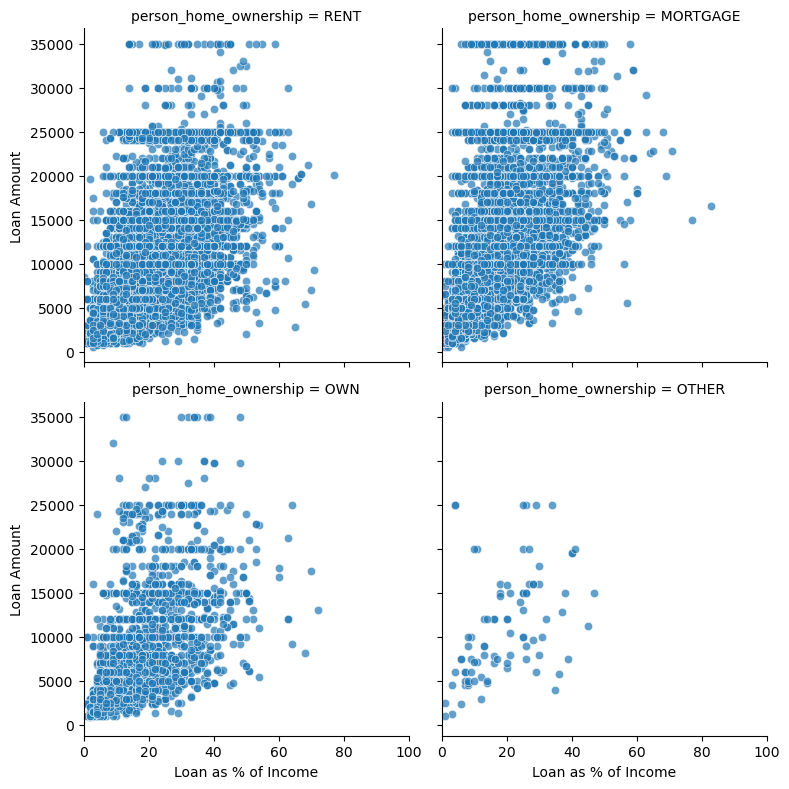

In [106]:


# Create a FacetGrid: one subplot per home ownership category
g = sns.FacetGrid(df, col="person_home_ownership", col_wrap=2, height=4)
g.map(sns.scatterplot, "loan_percent_income_pct", "loan_amnt", alpha=0.7)

# Set the x-axis limits and labels for clarity
g.set(xlim=(0, 100))
g.set_axis_labels("Loan as % of Income", "Loan Amount")
plt.tight_layout()
plt.show()

## Summary of Loan Intent and Home Ownership Segments

This table shows how different combinations of loan intent (e.g., EDUCATION, MEDICAL, PERSONAL) and home ownership (MORTGAGE, OWN, RENT, OTHER) compare in terms of average interest rate, average loan amount, and count of borrowers. We’ve sorted the table by average loan amount in descending order to identify which segments receive the largest lines of credit.

* Highest Averages: Segments like PERSONAL–OTHER and MEDICAL–OTHER appear near the top, suggesting they receive higher loan amounts (over $12,000 on average), but also tend to have higher interest rates (11–12%).

* Mortgage vs. Rent: Many MORTGAGE segments (e.g., DEBTCONSOLIDATION–MORTGAGE, EDUCATION–MORTGAGE) cluster in the middle, with average loan amounts around $10,000–$11,000 and interest rates near 10–10.6%. Renters often see slightly higher interest rates (11–12%) and somewhat lower loan amounts (around $8,000–$9,000).

* Low Counts: Some segments have very few borrowers (like DEBTCONSOLIDATION–OWN with a count of only 62), which may not be reliable for broad conclusions.

From the perspective of building an automated decision system, these patterns hint at where the bank’s profit opportunities and risks might lie. For instance, segments with higher average loan amounts but also higher interest rates could be more profitable—but might also carry greater default risk. Tracking how many borrowers fall into each segment (the “count” column) helps ensure the model doesn’t overly focus on small, potentially unrepresentative groups.


In [107]:
summary_table = (
    df
    .groupby(['loan_intent', 'person_home_ownership'], as_index=False)
    .agg(
        avg_interest_rate=('loan_int_rate', 'mean'),
        avg_loan_amount=('loan_amnt', 'mean'),
        count=('loan_amnt', 'count')  # how many borrowers in each segment
    )
)

# Sort by average loan amount (descending) to see which segments get the largest lines of credit
summary_table_sorted_by_amount = summary_table.sort_values('avg_loan_amount', ascending=False)

summary_table_sorted_by_amount



,loan_intent,person_home_ownership,avg_interest_rate,avg_loan_amount,count
17,PERSONAL,OTHER,11.675714,12366.666667,15
13,MEDICAL,OTHER,12.745000,12200.000000,13
5,EDUCATION,OTHER,12.400833,12142.857143,14
9,HOMEIMPROVEMENT,OTHER,11.683000,10959.090909,11
8,HOMEIMPROVEMENT,MORTGAGE,10.613916,10764.017341,1384
20,VENTURE,MORTGAGE,10.468000,10606.281060,1811
0,DEBTCONSOLIDATION,MORTGAGE,10.400489,10588.756111,1841
4,EDUCATION,MORTGAGE,10.554563,10502.178076,2089
12,MEDICAL,MORTGAGE,10.505553,10485.867052,1730
16,PERSONAL,MORTGAGE,10.426285,10481.223233,1868


## Training and evaluating our Logistic Regression model
I used a logistic regression model to predict whether a prospective borrower will default on a loan. After preprocessing the data—by standardizing numerical features and one-hot encoding categorical variables. I removed rows with missing values, and split the dataset into training and test sets. The model achieved a test accuracy of about 84.2%.

The confusion matrix provides additional insight into the model’s performance: 

* True Negatives (TN): 3,393 borrowers who did not default and were correctly predicted as non-default.

* False Positives (FP): 221 borrowers who did not default but were incorrectly flagged as defaults.

* False Negatives (FN): 501 borrowers who defaulted but were missed by the model.

* True Positives (TP): 467 borrowers who defaulted and were correctly identified.

Our results suggest that while the model performs reasonably well overall, there is still a balance to be struck between avoiding false positives and false negatives. This is particularly important when designing an automated decision system for credit risk, because both profitability for the bank and equitable access to credit are critical. Further tuning of the threshold and exploration of additional features could help optimize the model even further for its intended purpose


In [108]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Drop rows with missing values
df_train = df_train.dropna(subset=numeric_features + categorical_features)




target = 'loan_status'
X = df_train.drop(columns=[target])
y = df_train[target]

numeric_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
                      'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])
X_transformed = preprocessor.fit_transform(X)

# Split the transformed data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=123
)

# Fit a logistic regression model using the preprocessed features
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Test Accuracy: 0.8424268878219118
Confusion Matrix:
 [[3393  221]
 [ 501  467]]


## Finding weight and threshold

In [109]:
df['loan_int_rate_decimal'] = df['loan_int_rate'] / 100.0

def profit_if_repaid(loan_amnt, loan_int_rate_decimal):
    """
    If the loan is repaid in full, the bank's profit is:
      loan_amnt * (1 + 0.25*loan_int_rate)^10 - loan_amnt
    """
    return loan_amnt * (1 + 0.25 * loan_int_rate) ** 10 - loan_amnt

def profit_if_default(loan_amnt, loan_int_rate_decimal):
    """
    If the borrower defaults, we assume default happens 3 years into the loan, 
    and the bank loses 70% of the principal:
      loan_amnt*(1 + 0.25*loan_int_rate)^3 - 1.7*loan_amnt
    """
    return loan_amnt * (1 + 0.25 * loan_int_rate) ** 3 - 1.7 * loan_amnt


We will now compute predicted probabilities (probability of default) for the training data

In [110]:
y_prob_train = model.predict_proba(X_train)[:, 1]  # column 1 = probability of default



In [112]:
# Split the transformed data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)
loan_amnt_array = X_train['loan_amnt'].to_numpy()
loan_int_rate_array = X_train['loan_int_rate_decimal'].to_numpy()
y_train_array = y_train.to_numpy()
profit_repaid = profit_if_repaid(loan_amnt_array, loan_int_rate_array)
profit_default = profit_if_default(loan_amnt_array, loan_int_rate_array)


KeyError: 'loan_int_rate_decimal'

Now we are going to find a threshold and identify teh best threshold

In [ ]:
# 5. Sweep over thresholds to find the one that maximizes average profit

thresholds = np.linspace(0, 1, 101)
avg_profits = []

for t in thresholds:
    # Predict default if probability >= t
    predicted_default = (y_prob_train >= t).astype(int)
      # If we predict default, we do NOT give the loan => profit = 0
    # If we predict no default, we DO give the loan => actual profit depends on y_train_array
    #    - If actual y=0 (no default), profit = profit_repaid
    #    - If actual y=1 (default), profit = profit_default
    give_loan = 1 - predicted_default  # 1 = give loan, 0 = no loan
    # total_profit[i] = give_loan[i] * [ (1 - y[i])*profit_repaid[i] + y[i]*profit_default[i] ]
    total_profit = give_loan * ((1 - y_train_array) * profit_repaid + y_train_array * profit_default)
    
    # Compute average profit per borrower
    avg_profit = total_profit.mean()
    avg_profits.append(avg_profit)

avg_profits = np.array(avg_profits)

# 6. Identify the best threshold

best_idx = np.argmax(avg_profits) # index of the best threshold
best_threshold = thresholds[best_idx]


print(f"Best Threshold: {best_threshold:.3f}")


Best Threshold: 1.000


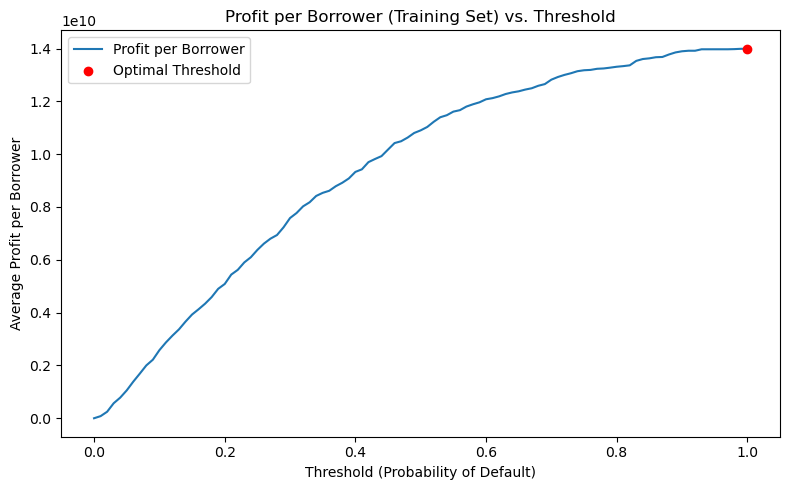

In [ ]:
# 7. Plot profit vs. threshold

plt.figure(figsize=(8, 5))
plt.plot(thresholds, avg_profits, label='Profit per Borrower')
plt.scatter(best_threshold, best_profit, color='red', zorder=10, label='Optimal Threshold')
plt.title('Profit per Borrower (Training Set) vs. Threshold')
plt.xlabel('Threshold (Probability of Default)')
plt.ylabel('Average Profit per Borrower')
plt.legend()
plt.tight_layout()
plt.show()